## Smunch User Cluster Analysis

The below analyzes the smunch user base annd attempts to cluster the users into three categories:
* Protien
* Vegetarian
* Vegan

In [1]:
## Initialization and imports
import pandas as pd 
import numpy as np
from matplotlib import pyplot as plt
from collections import Counter

import seaborn as sns

## Changing directory to top folder (All programs run from top)
import os
os.chdir('/Users/nschumacher/docs/galvanize/smunch-user-food-analysis')

## local run sql file
from db.python_db import run_sql_query

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

from scipy.spatial.distance import pdist
from scipy.spatial.distance import squareform
from scipy.cluster.hierarchy import dendrogram, linkage

%matplotlib inline  
%config InlineBackend.figure_format='retina'

## Set random seed
np.random.seed(seed=14)

In [2]:
meal_cat = run_sql_query("SELECT * FROM bi.dish_profiles_static")

q = '''
SELECT
    contact_sfid as user_id,
    ARRAY_AGG(product_sfid) as product_sfids
FROM
    bi.executed_order_employee
WHERE
    order_type = 'single'
GROUP BY
    contact_sfid'''

user_meals_df = run_sql_query(q)

In [3]:
meal_cat.set_index('product_sfid', inplace=True)
meal_cat.sample(3)

,mece_category,is_lc,is_gf,is_lf,type
product_sfid,,,,,
a050N0000124ZwRQAU,Vegan/HC/GF/LF,False,True,True,Vegan
a050N000010WsiXQAS,Animal protein/HC//,False,False,False,Animal protein
a050N0000125yqKQAQ,Animal protein/LC/GF/,True,True,False,Animal protein


In [4]:
user_meals_df.set_index('user_id', inplace=True)
user_meals_df.sample(3)

,product_sfids
user_id,
0030N00002LQpTeQAL,"[a050N00000zZfz0QAC, a050N00000zZg48QAC, a050N..."
0030N00002PriXQQAZ,"[a050N00000za4nqQAA, a050N000010W5f8QAC]"
0030N00002jEeX3QAK,"[a050N00000zZg8VQAS, a050N000010X9hrQAC, a050N..."


In [15]:
## Dictionary with meal id as key and type as value
meal_dict = meal_cat['type'].to_dict()

## Adding a meal count column so cann drop users with not enough meals
user_meals_df['meal_count'] = user_meals_df['product_sfids'].str.len()

## Drop customers with less than x orders
user_meals_df = user_meals_df[user_meals_df['meal_count'] > 30]

print("Left with {0} users.".format(user_meals_df.shape[0]))

Left with 2449 users.


In [40]:
## Convert meal_ids to their categories
def convert_product_ids(ids, meal_dict):
    categories = []
    for idd in ids:
        if idd in meal_dict.keys():
            categories.append(meal_dict[idd])
    
    counts = Counter(categories)
    return (counts['Vegan'], counts['Vegetarian'], counts['Animal protein'])

user_cat_counts = user_meals_df['product_sfids'].apply(convert_product_ids, args=(meal_dict,))

In [41]:
user_cat_counts = pd.DataFrame(user_cat_counts)

In [42]:
## expand df.tags into its own dataframe
tags = user_cat_counts['product_sfids'].apply(pd.Series)
tags.rename(columns={0:'vegan', 1:'vegetarian', 2:'animal'}, inplace=True)
tags.head(3)

,vegan,vegetarian,animal
user_id,,,
0030N00002aHyTcQAK,18,20,38
0030N00002aI2XlQAK,0,7,59
0030N00002aIjqrQAC,0,2,34


In [43]:
## Add a total categorized meals column
tags['total'] = tags.sum(axis=1)
tags.head(3)

,vegan,vegetarian,animal,total
user_id,,,,
0030N00002aHyTcQAK,18,20,38,76
0030N00002aI2XlQAK,0,7,59,66
0030N00002aIjqrQAC,0,2,34,36


In [44]:
## Getting frequency of each
cols = ['vegan', 'vegetarian', 'animal']
for col in cols:
    tags[col] = np.round((tags[col] / tags['total']), 3)
tags.head()

,vegan,vegetarian,animal,total
user_id,,,,
0030N00002aHyTcQAK,0.237,0.263,0.500,76
0030N00002aI2XlQAK,0.000,0.106,0.894,66
0030N00002aIjqrQAC,0.000,0.056,0.944,36
0030N00002aIlJAQA0,0.067,0.178,0.756,90
0030N00002b96PwQAI,0.244,0.378,0.378,45


/Users/nschumacher/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: pandas.scatter_matrix is deprecated. Use pandas.plotting.scatter_matrix instead
  """Entry point for launching an IPython kernel.


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a22486518>,
      dtype=object)

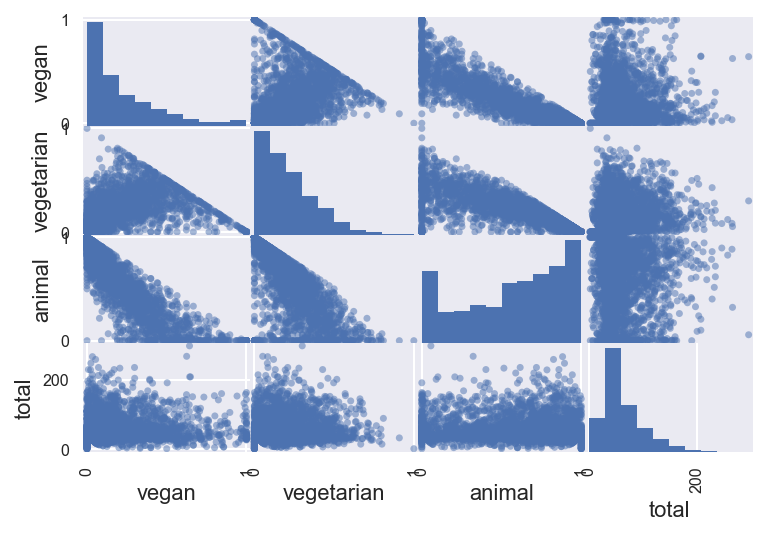

In [45]:
pd.scatter_matrix(tags)

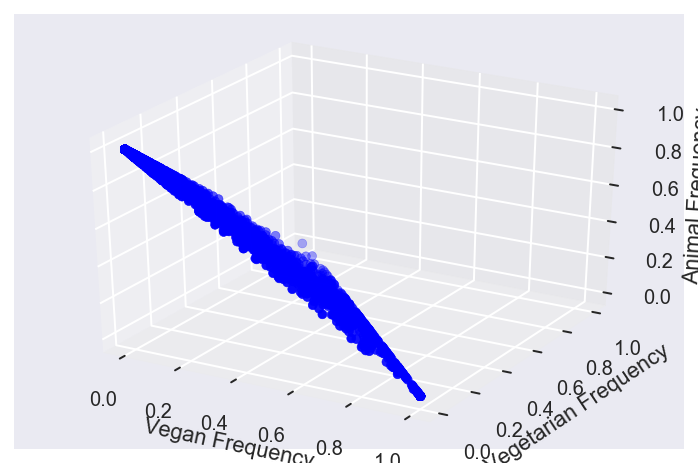

In [46]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(tags.vegan, tags.vegetarian, tags.animal, c='b', marker='o')

ax.set_xlabel('Vegan Frequency')
ax.set_ylabel('Vegetarian Frequency')
ax.set_zlabel('Animal Frequency')
plt.show()

In [61]:
print("{0:4.2f}% of customers who order vegan 90% of the time.".format(np.mean(tags.vegan > .9)*100))
print("{0:4.2f}% of customers who order vegan 90% of the time.".format(np.mean(tags.vegetarian > .9)*100))
print("{0:4.2f}% of customers who order vegan 90% of the time.".format(np.mean(tags.animal > .99)*100))

2.20% of customers who order vegan 90% of the time.
0.08% of customers who order vegan 90% of the time.
4.12% of customers who order vegan 90% of the time.
